# Entrono #

In [111]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor

In [112]:
# ----------------------------
# Pub/Sub Broker
# ----------------------------
class PubSubBroker:
    def __init__(self):
        self.subscribers = []

    def subscribe(self, callback):
        self.subscribers.append(callback)

    def publish(self, data):
        for callback in self.subscribers:
            callback(data)

# ----------------------------
# Whiteboard (memoria compartida)
# ----------------------------
class Whiteboard:
    def __init__(self):
        self.data = {}

    def write(self, key, value):
        self.data[key] = value

    def read(self):
        while len(self.data) < 2:
            print("Esperando datos en la pizarra... ", self.data)
            time.sleep(5)
        return dict(self.data)

    def clear(self):
        self.data = {}

# ----------------------------
# DataFetcher (Insertar agente de recolección de datos)
# ----------------------------
class DataFetcher:
    def __init__(self, dataframe):
        self.df = dataframe
        self.index = 0

    def has_next(self):
        return self.index < len(self.df)
    
    def get_next_ticker(self):
        if self.index < len(self.df):
            return self.df.iloc[self.index]['Ticker']
        return None

    def fetch_data(self):
        current = self.df.loc[self.index]
        self.index += 1
        return current
# ----------------------------

In [113]:
class traditionalAgent:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.data_fetcher = data_fetcher
        self.df = None
        self.broker.subscribe(self.group_traditional)

    def set_dataframe(self, df):
        self.df = df

    def group_traditional(self, data):
        idx = self.data_fetcher.index
        if idx < 2 or self.df is None:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Filtrar histórico por ticker actual
        df_hist = self.df.iloc[:idx].copy()
        df_hist = df_hist[df_hist['Ticker'] == data['Ticker']].reset_index(drop=True)

        if len(df_hist) < 10:
            self.whiteboard.write('trad_pred', data['Close'])
            return

        # Columnas predictoras
        features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA_20', 'MACD']

        # Objetivo: Close futuro (t+1)
        df_hist['Close_Future'] = df_hist['Close'].shift(-1)
        df_hist = df_hist.fillna(method='ffill')

        try:
            X = df_hist[features]
            y = df_hist['Close_Future']
            current_features = np.array([data[f] for f in features]).reshape(1, -1)

            # pred1: Regresión lineal multivariable
            model1 = LinearRegression()
            model1.fit(X, y)
            pred1 = model1.predict(current_features)[0]

            # pred2: Gradient Boosting multivariable
            model2 = GradientBoostingRegressor()
            model2.fit(X, y)
            pred2 = model2.predict(current_features)[0]

        except Exception:
            pred1 = pred2 = data['Close']

        avg = (pred1 + pred2) / 2
        self.whiteboard.write('trad_pred', avg)

In [114]:
class agenteIA:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.broker.subscribe(self.group_ai)
        self.data_fetcher = data_fetcher

    def group_ai(self, data):
        if self.data_fetcher.index > 1:
            last_close = df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
        pred1 = last_close * random.uniform(0.95, 1.05)
        pred2 = last_close * random.uniform(0.95, 1.05)
        avg = (pred1 + pred2) / 2
        self.whiteboard.write('ai_pred', avg)
        
    def set_dataframe():
        self.df = self.df

In [115]:
# ----------------------------
# MarketEnvironment
# ----------------------------
class MarketEnvironment:
    def __init__(self, df):
        self.df = df
        self.data_fetcher = DataFetcher(df)
        self.broker = PubSubBroker()
        self.whiteboard = Whiteboard()
        self.histories = {}  # Diccionario para almacenar cada empresa

        # Agentes de predicción
        self.agentsTraditional = traditionalAgent(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsIA = agenteIA(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsTraditional.set_dataframe(df)

        # Suscribir los grupos de agentes al broker
        self.broker.subscribe(self.agentsTraditional.group_traditional)
        self.broker.subscribe(self.agentsIA.group_ai)

    def run(self):
        tickers = self.df['Ticker'].unique().tolist()

        for ticker in tickers:
            print(f"Iniciando simulación para {ticker}...")

            df_ticker = self.df[self.df['Ticker'] == ticker].reset_index(drop=True)
            self.data_fetcher = DataFetcher(df_ticker)
            self.agentsTraditional.set_dataframe(df_ticker)

            self.histories[ticker] = pd.DataFrame(columns=['Datetime', 'Real_Close', 'Trad_Prediction', 'AI_Prediction'])

            # Primer paso: hacer la primera predicción (usando t)
            if not self.data_fetcher.has_next():
                continue
            current_data = self.data_fetcher.fetch_data()
            self.whiteboard.clear()
            self.broker.publish(current_data)
            last_prediction = self.whiteboard.read()  # ← esto reemplaza a last_data

            while self.data_fetcher.has_next():
                current_data = self.data_fetcher.fetch_data()

                # Guardar la predicción previa (hecha en t) contra el valor real de t+1
                self.histories[ticker].loc[len(self.histories[ticker])] = [
                    current_data['Datetime'],
                    current_data['Close'],
                    last_prediction.get('trad_pred', current_data['Close']),
                    last_prediction.get('ai_pred', current_data['Close'])
                ]

                print(
                    f"[{current_data['Datetime']}] {ticker} | "
                    f"Real: {current_data['Close']:.2f} | "
                    f"Tradicional: {last_prediction.get('trad_pred', current_data['Close']):.2f} | "
                    f"IA: {last_prediction.get('ai_pred', current_data['Close']):.2f}"
                )

                # Hacer predicción para t+2 usando datos de t+1
                self.whiteboard.clear()
                self.broker.publish(current_data)
                last_prediction = self.whiteboard.read()

            self.plot_graph(ticker)
            self.histories[ticker].to_excel(f"simulacion_{ticker}.xlsx", index=False)
            print(f"✔ Terminó {ticker}")


    def plot_graph(self, ticker):
        history = self.histories[ticker]

        # Ignorar el primer punto
        history = history.iloc[1:]

        plt.figure(figsize=(12,5))
        plt.plot(history['Datetime'], history['Real_Close'], label='Precio Real', marker='o')
        plt.plot(history['Datetime'], history['Trad_Prediction'], label='Predicción Tradicional', linestyle='--', marker='x')
        plt.plot(history['Datetime'], history['AI_Prediction'], label='Predicción IA', linestyle='-.', marker='s')
        plt.legend()
        plt.title(f'Simulación Multiagente - {ticker}')
        plt.xlabel('Tiempo')
        plt.ylabel('Precio de Cierre')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Iniciando simulación para AAPL...
[2025-07-09 14:30:00] AAPL | Real: 207.80 | Tradicional: 209.91 | IA: 207.09
[2025-07-09 15:30:00] AAPL | Real: 207.80 | Tradicional: 207.80 | IA: 207.31
[2025-07-09 16:30:00] AAPL | Real: 208.92 | Tradicional: 207.80 | IA: 198.10
[2025-07-09 17:30:00] AAPL | Real: 209.73 | Tradicional: 208.92 | IA: 213.16
[2025-07-09 18:30:00] AAPL | Real: 209.89 | Tradicional: 209.73 | IA: 209.99
[2025-07-09 19:30:00] AAPL | Real: 211.11 | Tradicional: 209.89 | IA: 209.53
[2025-07-10 13:30:00] AAPL | Real: 212.01 | Tradicional: 211.11 | IA: 208.06
[2025-07-10 14:30:00] AAPL | Real: 212.98 | Tradicional: 212.01 | IA: 209.60
[2025-07-10 15:30:00] AAPL | Real: 212.08 | Tradicional: 212.98 | IA: 210.00
[2025-07-10 16:30:00] AAPL | Real: 212.62 | Tradicional: 212.08 | IA: 214.89
[2025-07-10 17:30:00] AAPL | Real: 212.60 | Tradicional: 212.62 | IA: 207.07
[2025-07-10 18:30:00] AAPL | Real: 212.57 | Tradicional: 212.60 | IA: 209.59
[2025-07-10 19:30:00] AAPL | Real: 212.42 

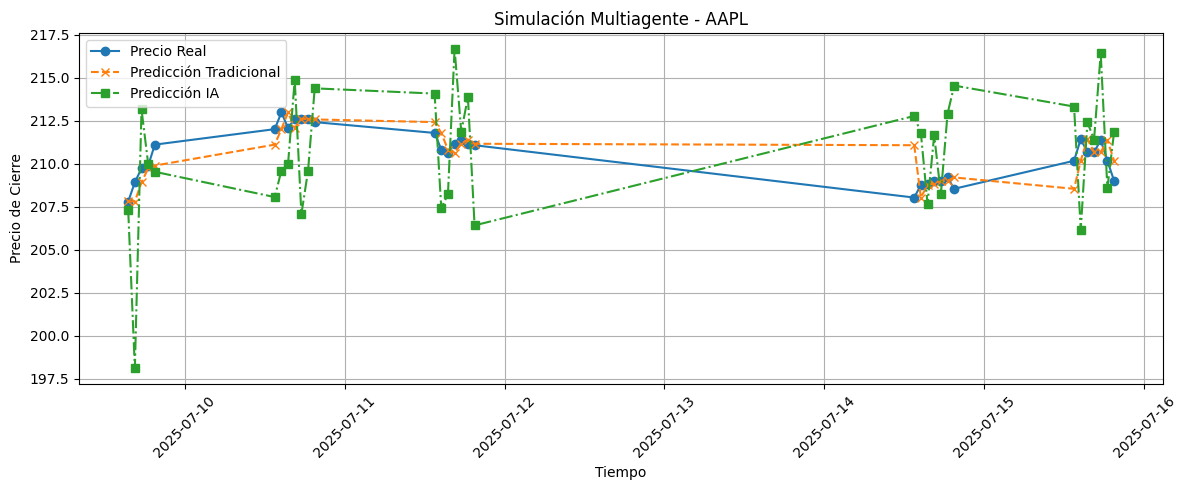

✔ Terminó AAPL
Iniciando simulación para MSFT...
[2025-07-09 14:30:00] MSFT | Real: 501.53 | Tradicional: 504.56 | IA: 509.34
[2025-07-09 15:30:00] MSFT | Real: 501.09 | Tradicional: 501.53 | IA: 501.27
[2025-07-09 16:30:00] MSFT | Real: 501.47 | Tradicional: 501.09 | IA: 485.48
[2025-07-09 17:30:00] MSFT | Real: 502.80 | Tradicional: 501.47 | IA: 490.84
[2025-07-09 18:30:00] MSFT | Real: 502.32 | Tradicional: 502.80 | IA: 507.96
[2025-07-09 19:30:00] MSFT | Real: 503.48 | Tradicional: 502.32 | IA: 508.20
[2025-07-10 13:30:00] MSFT | Real: 498.54 | Tradicional: 503.48 | IA: 505.06
[2025-07-10 14:30:00] MSFT | Real: 500.07 | Tradicional: 498.54 | IA: 514.99
[2025-07-10 15:30:00] MSFT | Real: 500.27 | Tradicional: 500.07 | IA: 515.81
[2025-07-10 16:30:00] MSFT | Real: 500.92 | Tradicional: 500.27 | IA: 487.56
[2025-07-10 17:30:00] MSFT | Real: 501.39 | Tradicional: 500.92 | IA: 517.97
[2025-07-10 18:30:00] MSFT | Real: 501.55 | Tradicional: 501.39 | IA: 497.80
[2025-07-10 19:30:00] MSFT 

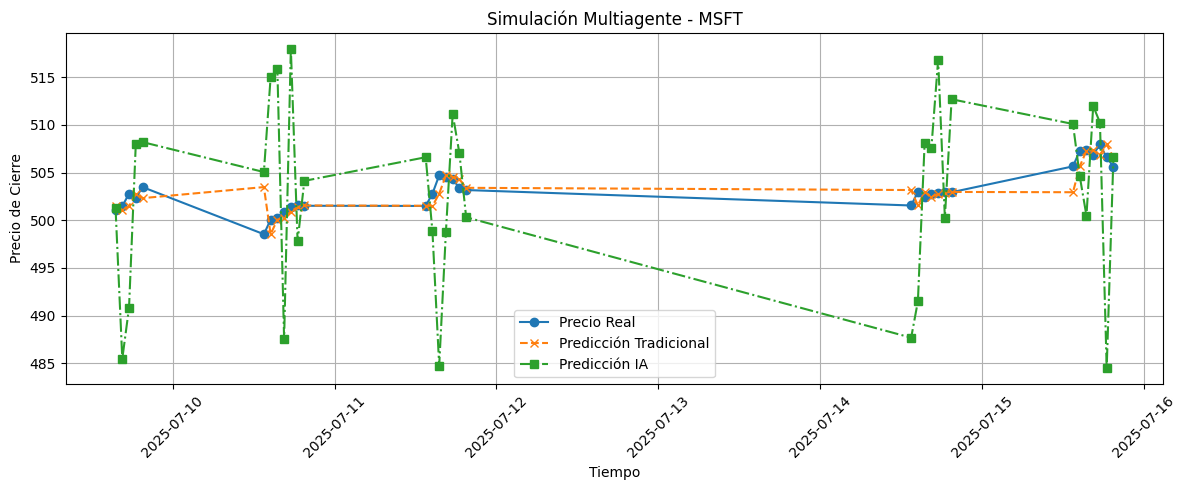

✔ Terminó MSFT
Iniciando simulación para GOOGL...
[2025-07-09 14:30:00] GOOGL | Real: 177.90 | Tradicional: 178.61 | IA: 179.35
[2025-07-09 15:30:00] GOOGL | Real: 176.99 | Tradicional: 177.90 | IA: 176.90
[2025-07-09 16:30:00] GOOGL | Real: 177.26 | Tradicional: 176.99 | IA: 178.57
[2025-07-09 17:30:00] GOOGL | Real: 176.24 | Tradicional: 177.26 | IA: 171.23
[2025-07-09 18:30:00] GOOGL | Real: 176.36 | Tradicional: 176.24 | IA: 174.63
[2025-07-09 19:30:00] GOOGL | Real: 176.70 | Tradicional: 176.36 | IA: 179.55
[2025-07-10 13:30:00] GOOGL | Real: 175.15 | Tradicional: 176.70 | IA: 174.05
[2025-07-10 14:30:00] GOOGL | Real: 176.36 | Tradicional: 175.15 | IA: 176.49
[2025-07-10 15:30:00] GOOGL | Real: 176.69 | Tradicional: 176.36 | IA: 173.68
[2025-07-10 16:30:00] GOOGL | Real: 178.17 | Tradicional: 176.69 | IA: 181.32
[2025-07-10 17:30:00] GOOGL | Real: 177.61 | Tradicional: 178.17 | IA: 178.24
[2025-07-10 18:30:00] GOOGL | Real: 177.76 | Tradicional: 177.61 | IA: 171.10
[2025-07-10 19

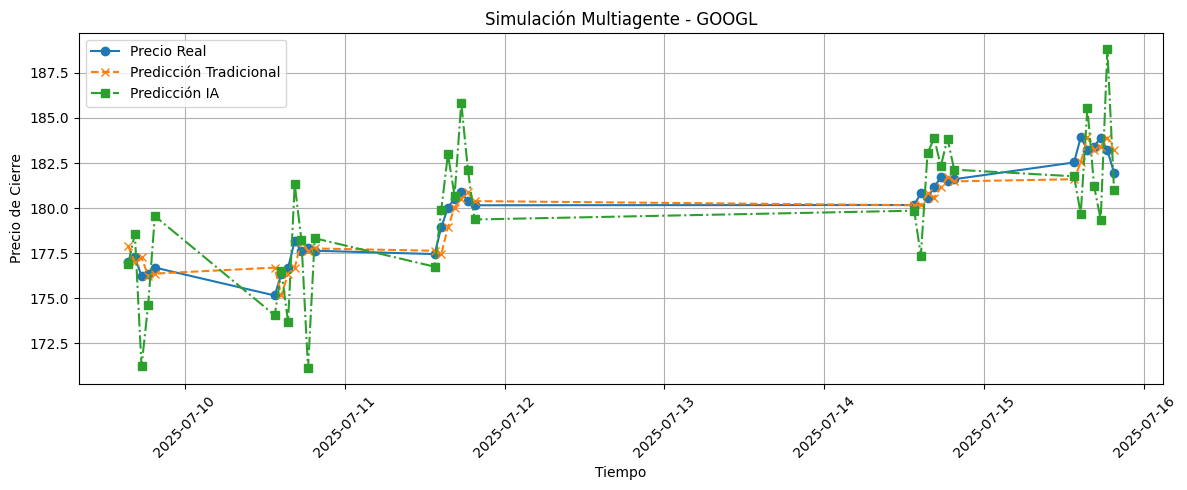

✔ Terminó GOOGL
Iniciando simulación para AMZN...
[2025-07-09 14:30:00] AMZN | Real: 222.37 | Tradicional: 222.89 | IA: 220.41
[2025-07-09 15:30:00] AMZN | Real: 222.40 | Tradicional: 222.37 | IA: 218.55
[2025-07-09 16:30:00] AMZN | Real: 222.61 | Tradicional: 222.40 | IA: 228.15
[2025-07-09 17:30:00] AMZN | Real: 222.41 | Tradicional: 222.61 | IA: 219.20
[2025-07-09 18:30:00] AMZN | Real: 222.58 | Tradicional: 222.41 | IA: 224.42
[2025-07-09 19:30:00] AMZN | Real: 222.47 | Tradicional: 222.58 | IA: 226.55
[2025-07-10 13:30:00] AMZN | Real: 220.26 | Tradicional: 222.47 | IA: 221.18
[2025-07-10 14:30:00] AMZN | Real: 221.63 | Tradicional: 220.26 | IA: 220.67
[2025-07-10 15:30:00] AMZN | Real: 222.09 | Tradicional: 221.63 | IA: 225.82
[2025-07-10 16:30:00] AMZN | Real: 222.29 | Tradicional: 222.09 | IA: 226.47
[2025-07-10 17:30:00] AMZN | Real: 222.60 | Tradicional: 222.29 | IA: 226.54
[2025-07-10 18:30:00] AMZN | Real: 222.06 | Tradicional: 222.60 | IA: 221.62
[2025-07-10 19:30:00] AMZN

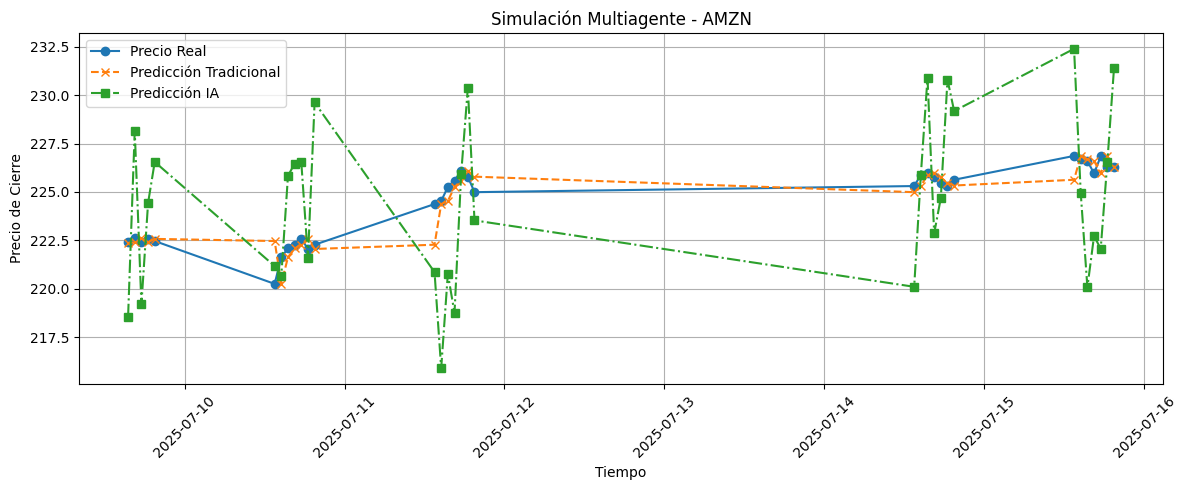

✔ Terminó AMZN
Iniciando simulación para NVDA...
[2025-07-09 14:30:00] NVDA | Real: 163.35 | Tradicional: 163.07 | IA: 155.40
[2025-07-09 15:30:00] NVDA | Real: 163.27 | Tradicional: 163.35 | IA: 165.39
[2025-07-09 16:30:00] NVDA | Real: 162.57 | Tradicional: 163.27 | IA: 160.79
[2025-07-09 17:30:00] NVDA | Real: 162.82 | Tradicional: 162.57 | IA: 167.83
[2025-07-09 18:30:00] NVDA | Real: 162.85 | Tradicional: 162.82 | IA: 164.79
[2025-07-09 19:30:00] NVDA | Real: 162.83 | Tradicional: 162.85 | IA: 162.69
[2025-07-10 13:30:00] NVDA | Real: 162.41 | Tradicional: 162.83 | IA: 162.53
[2025-07-10 14:30:00] NVDA | Real: 162.60 | Tradicional: 162.41 | IA: 163.12
[2025-07-10 15:30:00] NVDA | Real: 163.27 | Tradicional: 162.60 | IA: 156.09
[2025-07-10 16:30:00] NVDA | Real: 163.45 | Tradicional: 163.27 | IA: 156.86
[2025-07-10 17:30:00] NVDA | Real: 163.73 | Tradicional: 163.45 | IA: 162.88
[2025-07-10 18:30:00] NVDA | Real: 164.06 | Tradicional: 163.73 | IA: 167.83
[2025-07-10 19:30:00] NVDA 

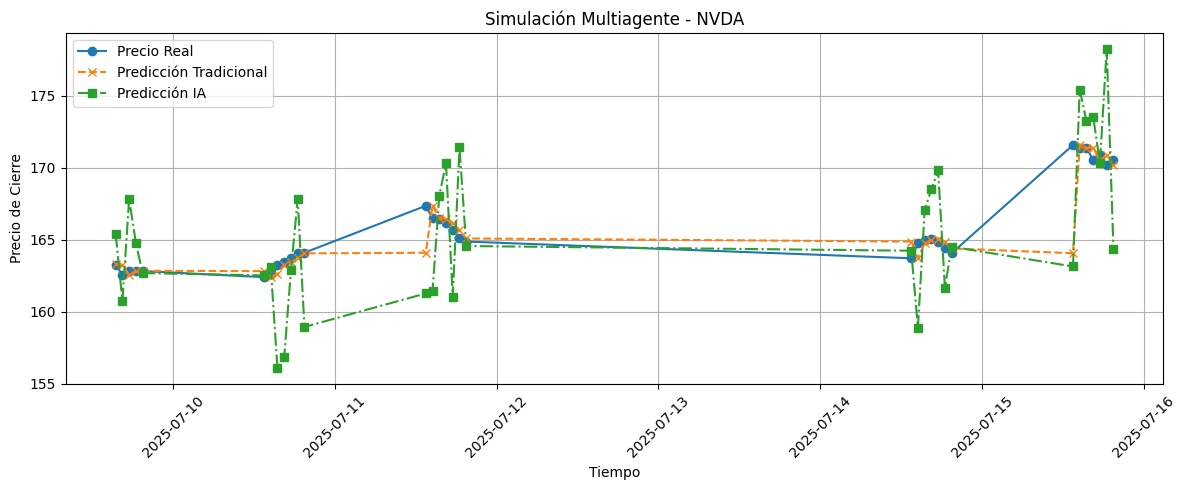

✔ Terminó NVDA
Iniciando simulación para META...
[2025-07-09 14:30:00] META | Real: 734.66 | Tradicional: 732.33 | IA: 754.10
[2025-07-09 15:30:00] META | Real: 735.57 | Tradicional: 734.66 | IA: 727.94
[2025-07-09 16:30:00] META | Real: 733.77 | Tradicional: 735.57 | IA: 727.84
[2025-07-09 17:30:00] META | Real: 734.66 | Tradicional: 733.77 | IA: 733.70
[2025-07-09 18:30:00] META | Real: 735.46 | Tradicional: 734.66 | IA: 751.29
[2025-07-09 19:30:00] META | Real: 732.80 | Tradicional: 735.46 | IA: 743.31
[2025-07-10 13:30:00] META | Real: 720.75 | Tradicional: 732.80 | IA: 766.27
[2025-07-10 14:30:00] META | Real: 726.93 | Tradicional: 720.75 | IA: 711.13
[2025-07-10 15:30:00] META | Real: 725.96 | Tradicional: 726.93 | IA: 740.88
[2025-07-10 16:30:00] META | Real: 725.53 | Tradicional: 725.96 | IA: 723.73
[2025-07-10 17:30:00] META | Real: 724.77 | Tradicional: 725.53 | IA: 731.87
[2025-07-10 18:30:00] META | Real: 726.43 | Tradicional: 724.77 | IA: 724.10
[2025-07-10 19:30:00] META 

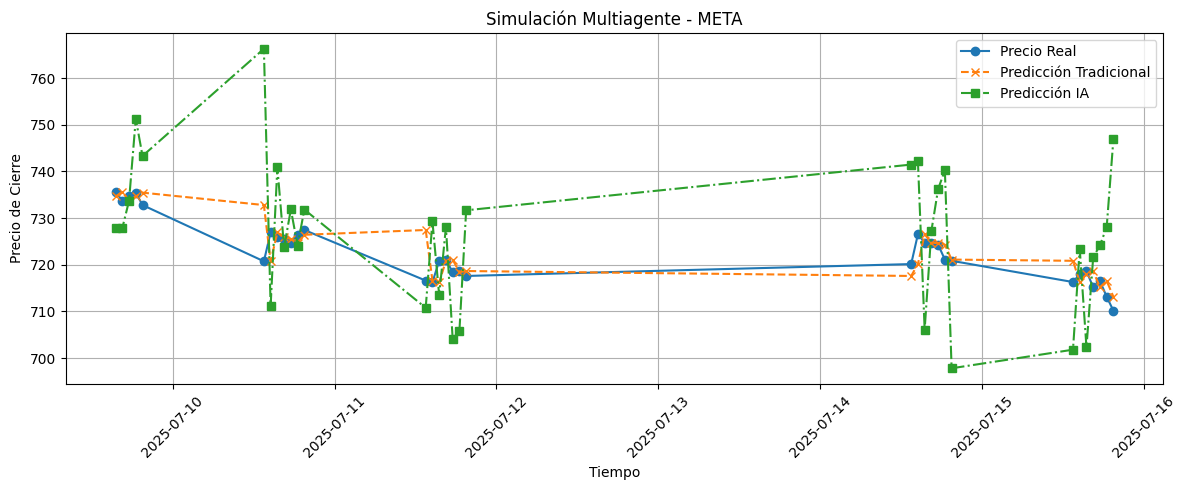

✔ Terminó META
Iniciando simulación para BRK-B...
[2025-07-09 14:30:00] BRK-B | Real: 477.12 | Tradicional: 477.90 | IA: 481.11
[2025-07-09 15:30:00] BRK-B | Real: 476.13 | Tradicional: 477.12 | IA: 489.86
[2025-07-09 16:30:00] BRK-B | Real: 477.38 | Tradicional: 476.13 | IA: 473.02
[2025-07-09 17:30:00] BRK-B | Real: 477.47 | Tradicional: 477.38 | IA: 484.25
[2025-07-09 18:30:00] BRK-B | Real: 478.24 | Tradicional: 477.47 | IA: 484.56
[2025-07-09 19:30:00] BRK-B | Real: 479.20 | Tradicional: 478.24 | IA: 472.82
[2025-07-10 13:30:00] BRK-B | Real: 477.81 | Tradicional: 479.20 | IA: 486.37
[2025-07-10 14:30:00] BRK-B | Real: 477.14 | Tradicional: 477.81 | IA: 475.55
[2025-07-10 15:30:00] BRK-B | Real: 476.52 | Tradicional: 477.14 | IA: 498.44
[2025-07-10 16:30:00] BRK-B | Real: 476.12 | Tradicional: 476.52 | IA: 462.56
[2025-07-10 17:30:00] BRK-B | Real: 476.51 | Tradicional: 476.12 | IA: 462.61
[2025-07-10 18:30:00] BRK-B | Real: 476.86 | Tradicional: 476.51 | IA: 474.59
[2025-07-10 19

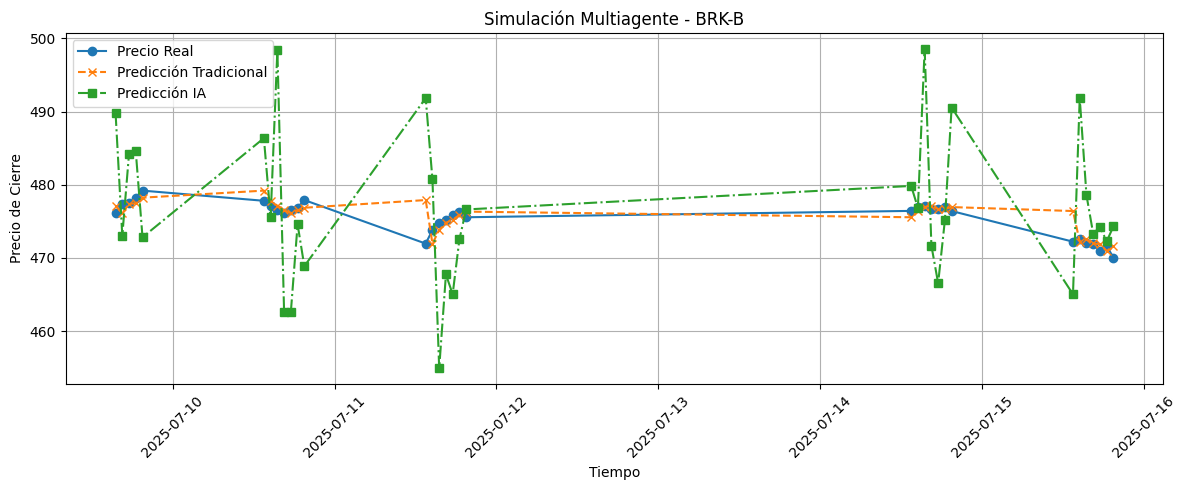

✔ Terminó BRK-B
Iniciando simulación para TSLA...
[2025-07-09 14:30:00] TSLA | Real: 295.93 | Tradicional: 295.45 | IA: 302.82
[2025-07-09 15:30:00] TSLA | Real: 294.85 | Tradicional: 295.93 | IA: 299.49
[2025-07-09 16:30:00] TSLA | Real: 294.51 | Tradicional: 294.85 | IA: 291.17
[2025-07-09 17:30:00] TSLA | Real: 296.58 | Tradicional: 294.51 | IA: 295.48
[2025-07-09 18:30:00] TSLA | Real: 296.94 | Tradicional: 296.58 | IA: 295.23
[2025-07-09 19:30:00] TSLA | Real: 295.82 | Tradicional: 296.94 | IA: 300.31
[2025-07-10 13:30:00] TSLA | Real: 304.35 | Tradicional: 295.82 | IA: 290.41
[2025-07-10 14:30:00] TSLA | Real: 304.69 | Tradicional: 304.35 | IA: 309.57
[2025-07-10 15:30:00] TSLA | Real: 304.02 | Tradicional: 304.69 | IA: 311.37
[2025-07-10 16:30:00] TSLA | Real: 301.89 | Tradicional: 304.02 | IA: 307.19
[2025-07-10 17:30:00] TSLA | Real: 306.53 | Tradicional: 301.89 | IA: 310.15
[2025-07-10 18:30:00] TSLA | Real: 309.24 | Tradicional: 306.53 | IA: 304.69
[2025-07-10 19:30:00] TSLA

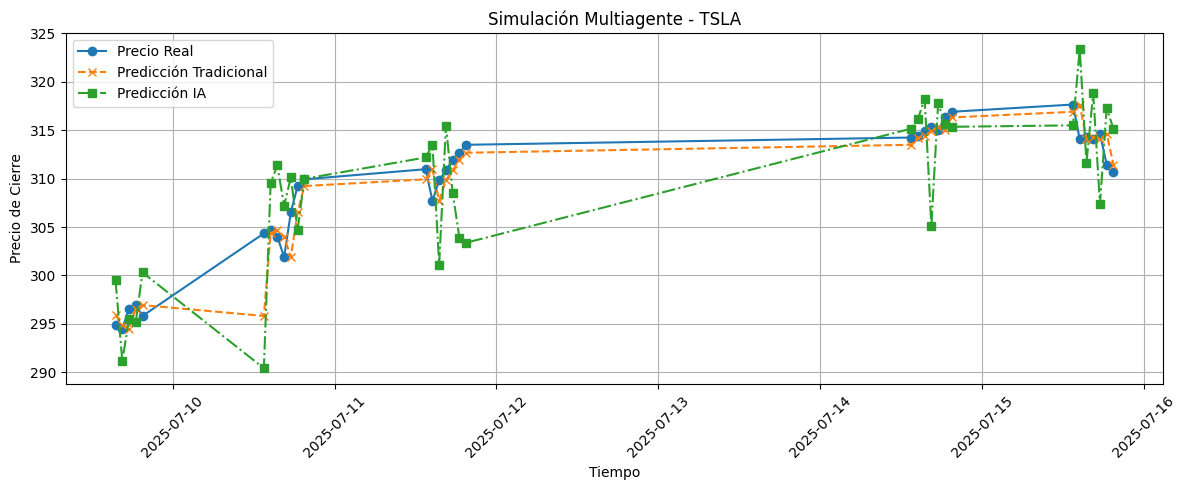

✔ Terminó TSLA
Iniciando simulación para TSM...
[2025-07-09 14:30:00] TSM | Real: 231.07 | Tradicional: 231.19 | IA: 227.25
[2025-07-09 15:30:00] TSM | Real: 232.05 | Tradicional: 231.07 | IA: 225.82
[2025-07-09 16:30:00] TSM | Real: 232.40 | Tradicional: 232.05 | IA: 226.43
[2025-07-09 17:30:00] TSM | Real: 232.86 | Tradicional: 232.40 | IA: 231.89
[2025-07-09 18:30:00] TSM | Real: 232.57 | Tradicional: 232.86 | IA: 235.57
[2025-07-09 19:30:00] TSM | Real: 231.88 | Tradicional: 232.57 | IA: 232.84
[2025-07-10 13:30:00] TSM | Real: 229.21 | Tradicional: 231.88 | IA: 226.22
[2025-07-10 14:30:00] TSM | Real: 230.07 | Tradicional: 229.21 | IA: 224.23
[2025-07-10 15:30:00] TSM | Real: 229.83 | Tradicional: 230.07 | IA: 225.43
[2025-07-10 16:30:00] TSM | Real: 230.04 | Tradicional: 229.83 | IA: 230.14
[2025-07-10 17:30:00] TSM | Real: 229.80 | Tradicional: 230.04 | IA: 224.78
[2025-07-10 18:30:00] TSM | Real: 229.87 | Tradicional: 229.80 | IA: 230.04
[2025-07-10 19:30:00] TSM | Real: 229.91

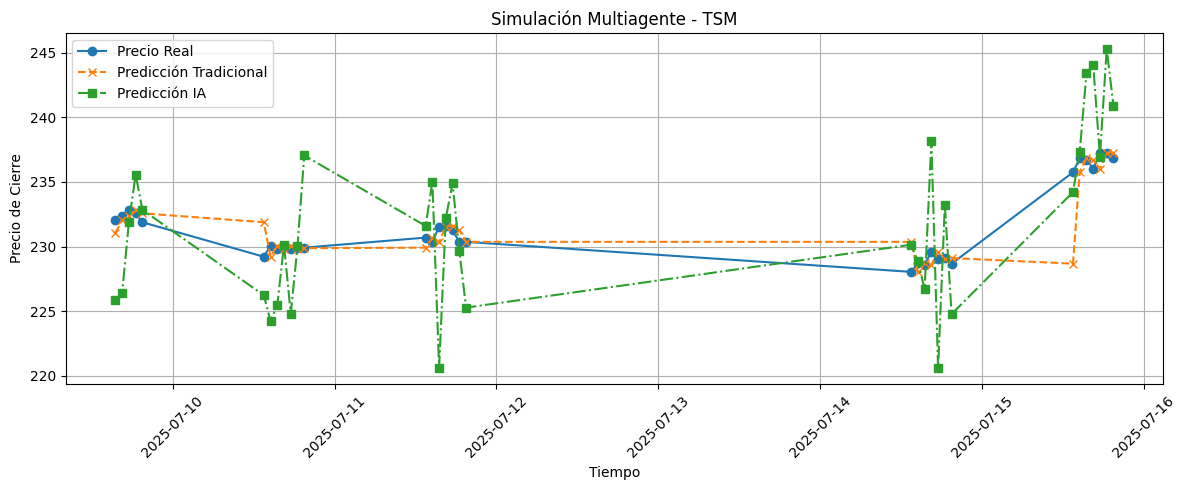

✔ Terminó TSM
Iniciando simulación para JPM...
[2025-07-09 14:30:00] JPM | Real: 283.94 | Tradicional: 283.89 | IA: 282.92
[2025-07-09 15:30:00] JPM | Real: 283.22 | Tradicional: 283.94 | IA: 294.49
[2025-07-09 16:30:00] JPM | Real: 283.58 | Tradicional: 283.22 | IA: 278.67
[2025-07-09 17:30:00] JPM | Real: 283.02 | Tradicional: 283.58 | IA: 278.67
[2025-07-09 18:30:00] JPM | Real: 282.79 | Tradicional: 283.02 | IA: 279.85
[2025-07-09 19:30:00] JPM | Real: 283.04 | Tradicional: 282.79 | IA: 286.70
[2025-07-10 13:30:00] JPM | Real: 285.62 | Tradicional: 283.04 | IA: 283.08
[2025-07-10 14:30:00] JPM | Real: 286.95 | Tradicional: 285.62 | IA: 276.71
[2025-07-10 15:30:00] JPM | Real: 287.21 | Tradicional: 286.95 | IA: 285.95
[2025-07-10 16:30:00] JPM | Real: 287.35 | Tradicional: 287.21 | IA: 285.54
[2025-07-10 17:30:00] JPM | Real: 287.56 | Tradicional: 287.35 | IA: 288.04
[2025-07-10 18:30:00] JPM | Real: 287.95 | Tradicional: 287.56 | IA: 283.12
[2025-07-10 19:30:00] JPM | Real: 288.10 

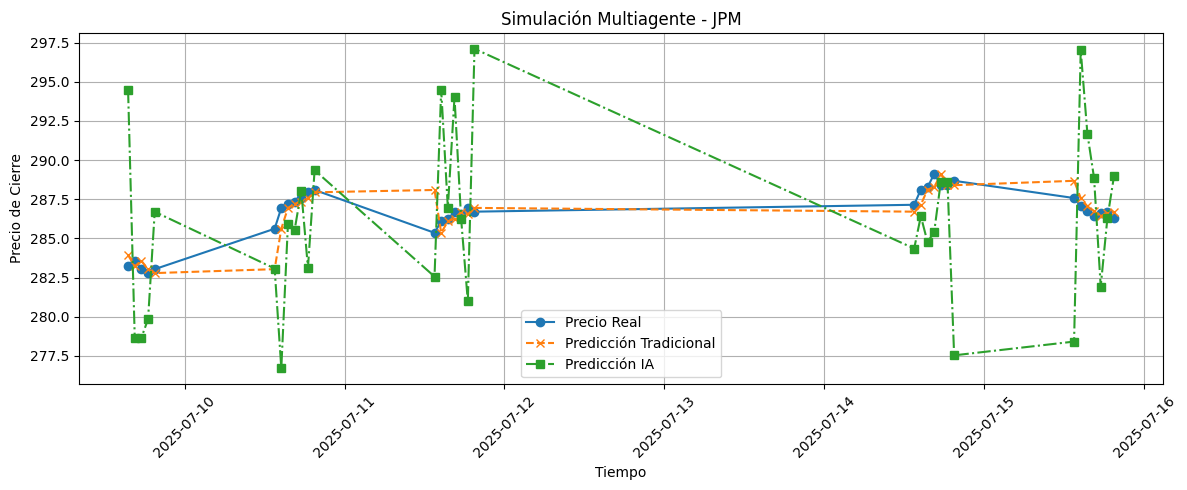

✔ Terminó JPM


In [117]:
# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # Cargar datos
    df = pd.read_excel("historico_top10_indicadores_completos.xlsx")
    env = MarketEnvironment(df)
    env.run()